# NEED to run this command in your environment 
# pip install psycopg2-binary

In [1]:
# import the dependencies
import psycopg2
import pandas as pd
import numpy as np
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# Scikit-Learn and Shallow Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing

In [42]:
# TF and Keras-related imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras.utils
from keras import utils as np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import gradient_descent_v2

In [4]:
# make the connection string to AWS RDS Database
conn_string="host=housingaws-db.cnvxuytbvp1m.us-east-1.rds.amazonaws.com" +" port=5432" +" dbname=housing_database"+" user=postgres"  \
                  +" password=team2data"
#connect to RDS
conn = psycopg2.connect(conn_string)
print("Connected!")    

Connected!


In [5]:
# Read the data from RDS as Pandas 
housing_df=pd.read_sql_query("select * from housing",con=conn)
housing_df.head(10)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,...,0,0,120,0,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,...,0,0,0,0,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,Reg,Lvl,AllPub,...,0,0,0,0,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,3,2010,WD,Normal,189900
5,6,527105030,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,6,2010,WD,Normal,195500
6,7,527127150,120,RL,41.0,4920,Pave,Reg,Lvl,AllPub,...,170,0,0,0,0,4,2010,WD,Normal,213500
7,8,527145080,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,...,0,0,144,0,0,1,2010,WD,Normal,191500
8,9,527146030,120,RL,39.0,5389,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,3,2010,WD,Normal,236500
9,10,527162130,60,RL,60.0,7500,Pave,Reg,Lvl,AllPub,...,0,0,0,0,0,6,2010,WD,Normal,189000


# Exploring our DATA

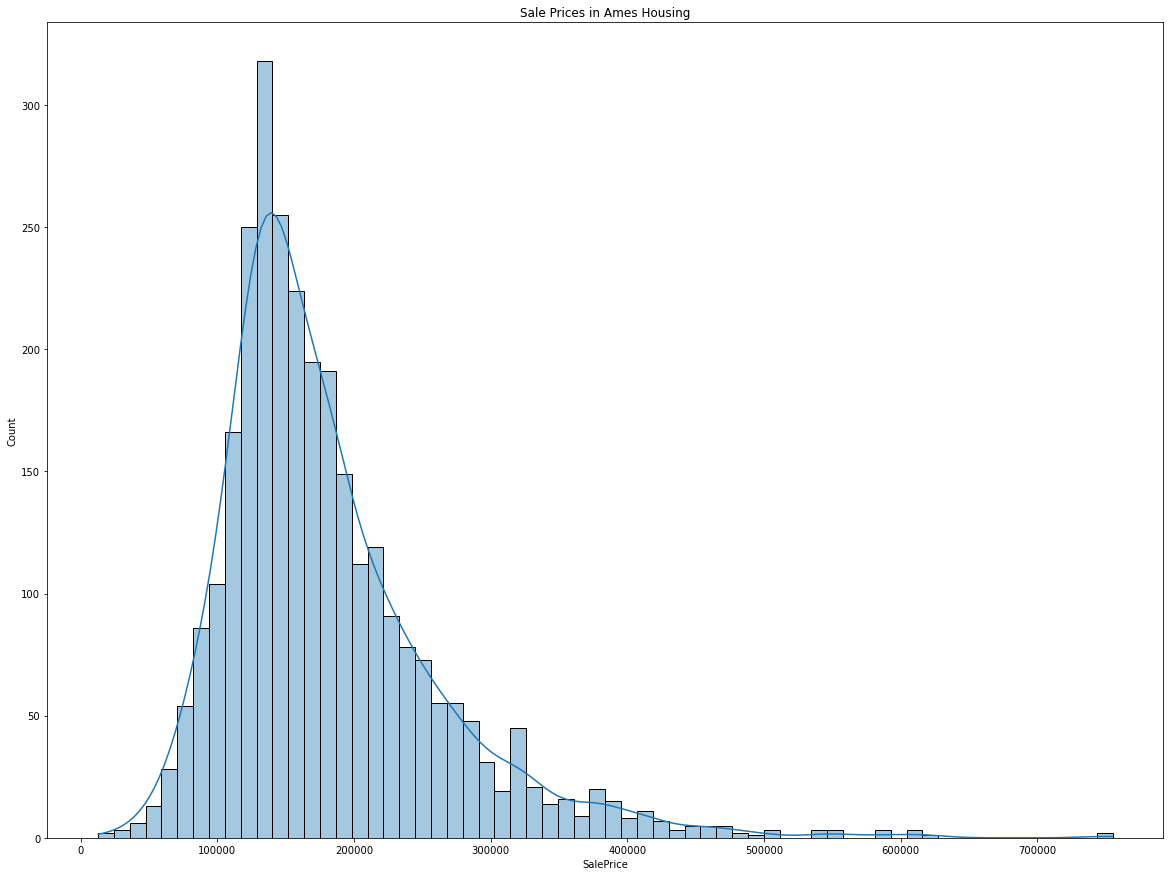

In [6]:
# We can analyze the distribution of the various sales prices on our home dataset 
fig, ax = plt.subplots(figsize=(20,15))
sns.histplot(x=housing_df['SalePrice'], kde=True, ax=ax, alpha=0.4).set(title = "Sale Prices in Ames Housing")
plt.show()

<AxesSubplot:xlabel='SalePrice'>

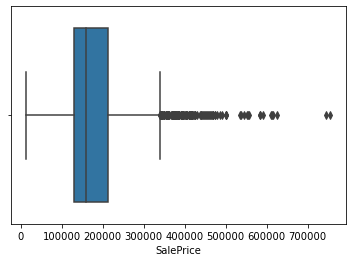

In [7]:
# Boxplot 

sns.boxplot(x=housing_df["SalePrice"])

In [8]:
# Description of the Interquartile ranges 

print(housing_df['SalePrice'].describe())

count      2930.000000
mean     180796.060068
std       79886.692357
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64


# We could further inspect outliers (this is something to explore over the next deliverable)
# Use heatmap or another way to show correaltion

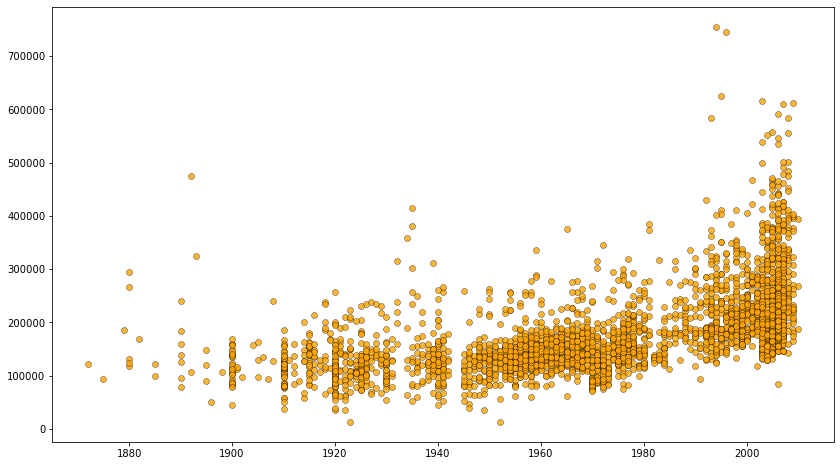

In [9]:
# Examining Correlation amongst features: 

fig, ax = plt.subplots(figsize=(14,8))
ax.scatter(
    x=housing_df['Year Built'],
    y=housing_df['SalePrice'],
    color='orange',
    edgecolors='black',
    linewidths=0.4,
    alpha=0.8,
    )

plt.show()

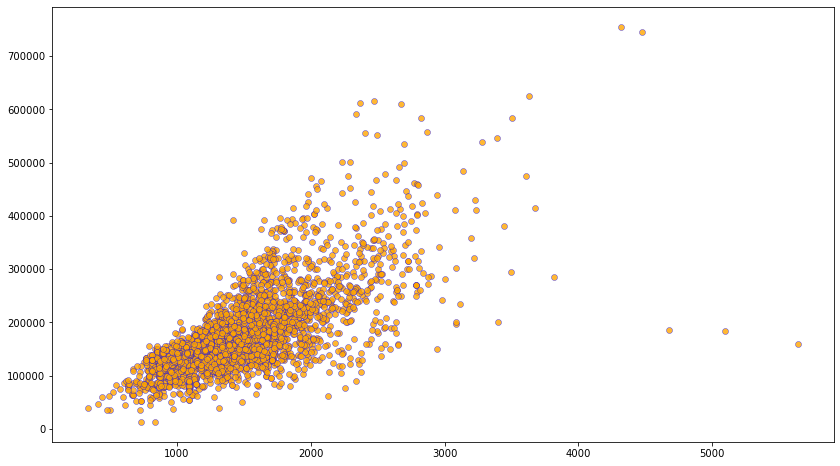

In [10]:
# Living Area vs Sales Price 

fig, ax = plt.subplots(figsize=(14,8))
ax.scatter(
    x=housing_df['Gr Liv Area'],
    y=housing_df['SalePrice'],
    color='orange',
    edgecolors='blue',
    linewidths=0.4,
    alpha=0.8,
    )

plt.show()

In [11]:
# DataPreprocessing:  

# Importance behind Data Preprocessing in our specfic scenario: 
# We might not have houses being sold in a normal condition
# We can have houses that might have had rush sales due to owner requiring money quickly
# We can have data missing for specific features which can skew our results

# Steps to tackle these issues: 
# 1. Identifying Missing Values 
# 2. Decide on what to do with the Missing Values, either remove column/rows or replace with mean value 
# 3. One-Hot Encoding of Categorical Variables ( we will turn our categorical variables in our numerical data type)
# 4. Observing Variable datatypes captured by Pandas, sometimes they provide incorrect data variable type 
# 5. Splitting our data into X_train, X_test, y_train & y_test 
# 6. Standardizing our variable except the target variable 


# exploring data, did you see any trend? 
# what sort of analysis are you doing?

In [12]:
# Identifying the Number of Missing Values 

missing_values = pd.DataFrame({
    'Column': housing_df.columns.values,
    'Number of Missing Value': housing_df.isna().sum().values,
    'Missing Value %': 100 * housing_df.isna().sum().values / len(housing_df),})

missing_values = missing_values[missing_values['Number of Missing Value'] > 0]
print(missing_values.sort_values(by='Number of Missing Value').reset_index(drop=True))

            Column  Number of Missing Value  Missing Value %
0      Bsmt Unf SF                        1         0.034130
1      Garage Area                        1         0.034130
2      Garage Cars                        1         0.034130
3       Electrical                        1         0.034130
4    Total Bsmt SF                        1         0.034130
5      Garage Qual                        1         0.034130
6     BsmtFin SF 2                        1         0.034130
7      Garage Cond                        1         0.034130
8   BsmtFin Type 1                        1         0.034130
9        Bsmt Cond                        1         0.034130
10       Bsmt Qual                        1         0.034130
11    BsmtFin SF 1                        1         0.034130
12  BsmtFin Type 2                        2         0.068259
13  Bsmt Full Bath                        2         0.068259
14  Bsmt Half Bath                        2         0.068259
15   Garage Finish      

# Drop Variables with too many Missing Values

In [15]:
# Columns with Nan val("Alley","Pool QC","Fence","Misc Feature") already deleted from the database before uploading to rds
housing_df.drop(['Fireplace Qu', 'Lot Frontage'], axis=1, inplace=True)

housing_df.shape

(2930, 76)

In [16]:
# We must decide what we are going to do with all the other variables that have missing values and identify whether the variables are categorical or numerical 

cols_with_missing_values = housing_df.columns[housing_df.isna().sum() > 0]
for col in cols_with_missing_values:

# Print Info 
    
    print(col)
    print(housing_df[col].unique()[:5])

Mas Vnr Type
['Stone' 'None' 'BrkFace' None 'BrkCmn']
Mas Vnr Area
[112.   0. 108.  20. 603.]
Bsmt Qual
['TA' 'Gd' 'Ex' 'NA' 'Fa']
Bsmt Cond
['Gd' 'TA' 'NA' 'Po' 'Fa']
Bsmt Exposure
['Gd' 'No' 'Mn' 'Av' None]
BsmtFin Type 1
['BLQ' 'Rec' 'ALQ' 'GLQ' 'Unf']
BsmtFin SF 1
[ 639.  468.  923. 1065.  791.]
BsmtFin Type 2
['Unf' 'LwQ' 'BLQ' 'Rec' 'NA']
BsmtFin SF 2
[   0.  144. 1120.  163.  168.]
Bsmt Unf SF
[ 441.  270.  406. 1045.  137.]
Total Bsmt SF
[1080.  882. 1329. 2110.  928.]
Electrical
['SBrkr' 'FuseA' 'FuseF' 'FuseP' None]
Bsmt Full Bath
[ 1.  0.  2.  3. nan]
Bsmt Half Bath
[ 0.  1. nan  2.]
Garage Yr Blt
[1960. 1961. 1958. 1968. 1997.]
Garage Finish
['Fin' 'Unf' 'RFn' 'NA' None]
Garage Cars
[2. 1. 3. 0. 4.]
Garage Area
[528. 730. 312. 522. 482.]
Garage Qual
['TA' 'NA' 'Fa' 'Gd' 'Ex']
Garage Cond
['TA' 'NA' 'Fa' 'Gd' 'Ex']


In [17]:
# Train & Test Split onto the missing values

train_housing_df, test_housing_df = train_test_split(housing_df, test_size=0.2)

In [19]:
# Replacing the values of our numerical values 

num_with_missing = ['Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 
                    'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath', 
                    'Garage Yr Blt', 'Garage Cars', 'Garage Area']

for n_col in num_with_missing:
    train_housing_df[n_col] = train_housing_df[n_col].fillna(train_housing_df[n_col].mean())
    test_housing_df[n_col] = test_housing_df[n_col].fillna(test_housing_df[n_col].mean())

In [20]:
# Replacing the values of our categorical values

cat_with_missing = [x for x in cols_with_missing_values if x not in num_with_missing]

for c_col in cat_with_missing:
    train_housing_df[c_col] = train_housing_df[c_col].fillna(train_housing_df[c_col].mode().to_numpy()[0])
    test_housing_df[c_col] = test_housing_df[c_col].fillna(test_housing_df[c_col].mode().to_numpy()[0])
    
    
# Our dataset should not have any more missing variables at this point, we can run a code to double check if this is true


In [21]:
housing_df.isna().sum()

# ERROR spotted on LOT FRONTAGE Feature (figure out why this error is arising)

Order             0
PID               0
MS SubClass       0
MS Zoning         0
Lot Area          0
                 ..
Mo Sold           0
Yr Sold           0
Sale Type         0
Sale Condition    0
SalePrice         0
Length: 76, dtype: int64

# One Hot Encoding our Categorical Variables

In [22]:
# Checking our Variables Data Types & Confirm whether Pandas is reading any of these variables incorrectly 
data_types = pd.DataFrame({
    'Column': train_housing_df.select_dtypes(exclude='object').columns.values,
    'Data type': train_housing_df.select_dtypes(exclude='object').dtypes.values})

print(data_types)

             Column Data type
0             Order     int64
1               PID     int64
2       MS SubClass     int64
3          Lot Area     int64
4      Overall Qual     int64
5      Overall Cond     int64
6        Year Built     int64
7    Year Remod/Add     int64
8      Mas Vnr Area   float64
9      BsmtFin SF 1   float64
10     BsmtFin SF 2   float64
11      Bsmt Unf SF   float64
12    Total Bsmt SF   float64
13       1st Flr SF     int64
14       2nd Flr SF     int64
15  Low Qual Fin SF     int64
16      Gr Liv Area     int64
17   Bsmt Full Bath   float64
18   Bsmt Half Bath   float64
19        Full Bath     int64
20        Half Bath     int64
21    Bedroom AbvGr     int64
22    Kitchen AbvGr     int64
23    TotRms AbvGrd     int64
24       Fireplaces     int64
25    Garage Yr Blt   float64
26      Garage Cars   float64
27      Garage Area   float64
28     Wood Deck SF     int64
29    Open Porch SF     int64
30   Enclosed Porch     int64
31       3Ssn Porch     int64
32     Scr

In [23]:
# Perform One Hot Encoding 

accepted_vars = ['MS SubClass', 'Lot Area',
                 'Overall Qual', 'Overall Cond',
                 'Year Built', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF',
                 'Gr Liv Area', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 
                 'Kitchen AbvGr', 'TotRms AbvGrd', 'Garage Area', 
                 'Pool Area','SalePrice']

train_housing_df = train_housing_df[accepted_vars]
test_housing_df = test_housing_df[accepted_vars] 

In [24]:
train_housing_df = pd.get_dummies(train_housing_df).reset_index(drop=True)
test_housing_df = pd.get_dummies(test_housing_df).reset_index(drop=True)


In [25]:
print(test_housing_df)

     MS SubClass  Lot Area  Overall Qual  Overall Cond  Year Built  \
0             70     13132             5             5        1914   
1             80     10541             7             5        1996   
2             75      9600             6             5        1917   
3             20     17217             5             5        2006   
4             80      9620             6             7        1977   
..           ...       ...           ...           ...         ...   
581           20      7150             5             6        1966   
582          120      6240             8             5        2006   
583           20     23730             7             5        1996   
584           20     15240             5             8        1977   
585           50     10440             5             6        1910   

     Total Bsmt SF  1st Flr SF  2nd Flr SF  Gr Liv Area  Full Bath  Half Bath  \
0            747.0         892         892         1784          1          1 

In [26]:
print (train_housing_df)
housing_df.shape

      MS SubClass  Lot Area  Overall Qual  Overall Cond  Year Built  \
0              30     10200             4             6        1925   
1             160      2280             6             5        1999   
2              90      7711             4             3        1977   
3              50      5925             4             6        1900   
4              20      9158             8             5        2007   
...           ...       ...           ...           ...         ...   
2339           60      9600             6             6        1971   
2340          190      7000             5             5        1962   
2341           60     11194             8             5        2000   
2342           20     10200             8             5        2007   
2343           20      7315             5             6        1958   

      Total Bsmt SF  1st Flr SF  2nd Flr SF  Gr Liv Area  Full Bath  \
0             572.0         572           0          572          1   
1    

(2930, 76)

# Split Data into X_train, X_test, y_train & y_test

In [27]:
# Split Data :
# X_train - X_test - y_train - y_test

X_train, y_train = train_housing_df, train_housing_df.pop('SalePrice')
X_test, y_test = test_housing_df, test_housing_df.pop('SalePrice')

# Feature Scaling by using Standardization

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
print(X_train)

[[-0.64006482 -0.00769417 -1.47900629 ... -1.55051544 -1.24704275
  -0.06655184]
 [ 2.4217963  -0.93584846 -0.05702485 ... -0.28085319 -0.13980824
  -0.06655184]
 [ 0.77310185 -0.29938306 -1.47900629 ...  0.98880906 -2.16973817
  -0.06655184]
 ...
 [ 0.06651851  0.10879388  1.36495659 ...  0.35397793  0.15545429
  -0.06655184]
 [-0.8755926  -0.00769417  1.36495659 ...  0.35397793  1.56717829
  -0.06655184]
 [-0.8755926  -0.34579078 -0.76801557 ... -0.28085319 -0.61038291
  -0.06655184]]


In [30]:
print(X_test)

[[ 0.30204629  0.33591042 -0.76801557 ...  1.62364018 -1.33931229
  -0.06655184]
 [ 0.53757407  0.03226803  0.65396587 ...  0.98880906  0.00782302
  -0.06655184]
 [ 0.41981018 -0.07800889 -0.05702485 ...  0.98880906 -0.34280124
  -0.06655184]
 ...
 [-0.8755926   1.57790274  0.65396587 ...  0.35397793  1.45645484
  -0.06655184]
 [-0.8755926   0.58294947 -0.76801557 ... -0.91568431 -0.74878722
  -0.06655184]
 [-0.16900927  0.02043172 -0.76801557 ... -0.91568431 -0.13980824
  -0.06655184]]


# Shallow Learning (pip install xgboost)

In [32]:
import xgboost as xgb

In [35]:
# Initialize our Shallow Learning Regressors from Scikit-Learn 

linear_regressor = LinearRegression()
dtr = DecisionTreeRegressor() 
forest = RandomForestRegressor()
xgboost = xgb.XGBRegressor() 

In [36]:
# Fitting our Regressors: 

linear_regressor.fit(X_train, y_train) 
dtr.fit(X_train, y_train) 
forest.fit(X_train, y_train) 
xgboost.fit(X_train, y_train) 

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [37]:
# Making predictions on the test set
y_pred_linear = linear_regressor.predict(X_test) 
y_pred_dtr = dtr.predict(X_test) 
y_pred_forest = forest.predict(X_test)
y_pred_xgboost = xgboost.predict(X_test) 

In [39]:
y_pred_elastic = linear_regressor.predict(X_test)
y_pred_dtr = dtr.predict(X_test)
y_pred_forest = forest.predict(X_test)
y_pred_xgboost = xgboost.predict(X_test)

print('LinearRegressor Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_elastic))
print('LinearRegressor Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_elastic))
print('LinearRegressor Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_elastic)))
print('LinearRegressor Mean Absolute Percentage Error:', metrics.mean_absolute_percentage_error(y_test, y_pred_elastic)*100)
print('LinearRegressor Mean Squared Logarithmic Error', np.log(metrics.mean_squared_error(y_test, y_pred_linear)))

print('\n')

print('DTR Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_dtr))
print('DTR Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_dtr))
print('DTR Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_dtr)))
print('DTR Mean Absolute Percentage Error:', metrics.mean_absolute_percentage_error(y_test, y_pred_dtr)*100)
print('DTR Mean Squared Logarithmic Error', np.log(metrics.mean_squared_error(y_test, y_pred_dtr)))

print('\n')

print('RFR Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_forest))
print('RFR Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_forest))
print('RFR Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_forest)))
print('RFR Mean Absolute Percentage Error:', metrics.mean_absolute_percentage_error(y_test, y_pred_forest)*100)
print('RFR Mean Squared Logarithmic Error', np.log(metrics.mean_squared_error(y_test, y_pred_forest)))

print('\n')


print('XGBoost Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_xgboost))
print('XGBoost Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_xgboost))
print('XGBoost Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgboost)))
print('XGBoost Mean Absolute Percentage Error:', metrics.mean_absolute_percentage_error(y_test, y_pred_xgboost)*100)
print('XGBoost Mean Squared Logarithmic Error', np.log(metrics.mean_squared_error(y_test, y_pred_xgboost)))

LinearRegressor Mean Absolute Error: 20746.255394636617
LinearRegressor Mean Squared Error: 1226581110.72187
LinearRegressor Root Mean Squared Error: 35022.58001235589
LinearRegressor Mean Absolute Percentage Error: 12.28769215067271
LinearRegressor Mean Squared Logarithmic Error 20.9274965513326


DTR Mean Absolute Error: 24914.493174061434
DTR Mean Squared Error: 1577568139.6365187
DTR Root Mean Squared Error: 39718.61200541276
DTR Mean Absolute Percentage Error: 14.637039545669111
DTR Mean Squared Logarithmic Error 21.179150346145047


RFR Mean Absolute Error: 17169.185518012895
RFR Mean Squared Error: 798078335.4359663
RFR Root Mean Squared Error: 28250.280271812637
RFR Mean Absolute Percentage Error: 10.290460883868526
RFR Mean Squared Logarithmic Error 20.497717315302967


XGBoost Mean Absolute Error: 16367.438473229522
XGBoost Mean Squared Error: 708822494.358059
XGBoost Root Mean Squared Error: 26623.720520582
XGBoost Mean Absolute Percentage Error: 9.775959540571746
XGBoost Me

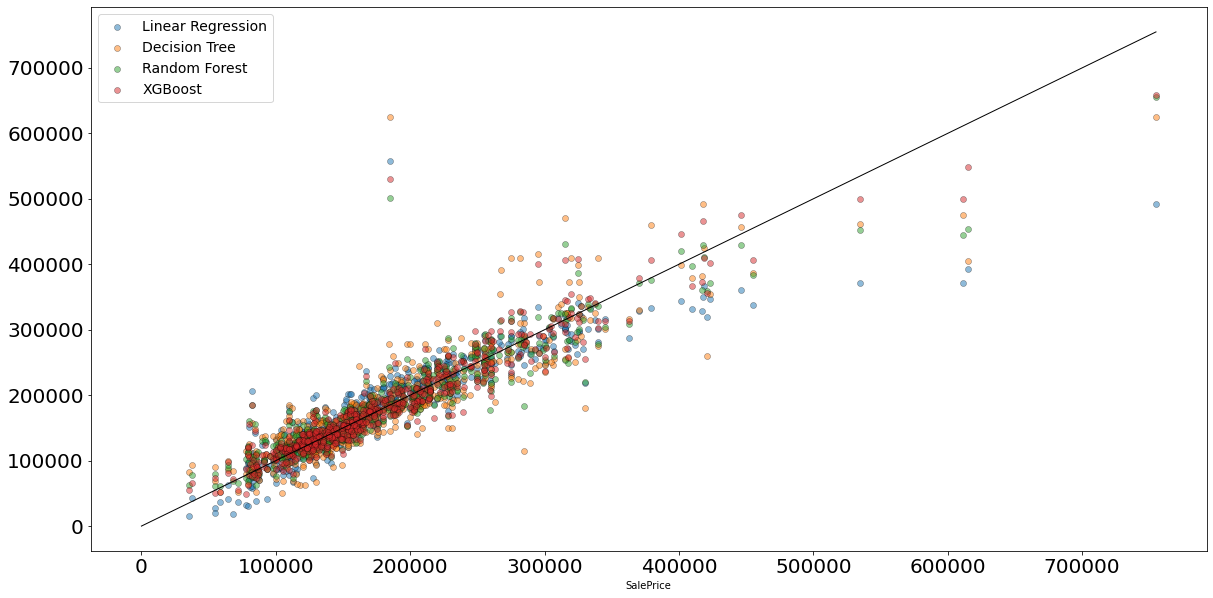

In [40]:
## Would be a great visual for our dashboard in telling our story and why we chose our decision

# We would want to visualize the predicted values in comparison to the real values in the test set: 

fig, ax = plt.subplots(figsize=(20,10)) 

# Scatterplots of predictions
sns.scatterplot(x=y_test, y=y_pred_linear, alpha=0.5, lw=1, ec='black', ax=ax, label='Linear Regression')
sns.scatterplot(x=y_test, y=y_pred_dtr, alpha=0.5, lw=1, ec='black', ax=ax, label='Decision Tree')
sns.scatterplot(x=y_test, y=y_pred_forest, alpha=0.5, lw=1, ec='black', ax=ax, label='Random Forest')
sns.scatterplot(x=y_test, y=y_pred_xgboost, alpha=0.5, lw=1, ec='black', ax=ax, label='XGBoost')

# Diagonal reference line
lims = [0, max(y_test.max(), y_test.max())]
plt.plot(lims, lims, lw=1, color='black')


# Visual: 
# Diagonal reference line
lims = [0, max(y_test.max(), y_test.max())]

# Legend and tick styling
plt.legend(prop={'size': 14})
plt.ticklabel_format(useOffset=False, style='plain')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

# Deep Learning

In [41]:
def define_model(loss_func):
    # Starting out with placeholder, single-layer network with 64 neurons each (educated guess)
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
        layers.Dropout(0.3, seed=2),
        layers.Dense(64, activation='swish'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    # Placeholder optimizer until we test different ones
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    
    model.compile(loss=loss_func,
                  optimizer=optimizer,
                  metrics=['mae', 'mse', 'mape'])
    
    return model

In [43]:
loss_functions = ['mse', 'mae', 'huber_loss', 'mape', 'mean_squared_logarithmic_error']
histories = []

for index, func in enumerate(loss_functions, 1):
    model = define_model(func)
    history = model.fit(
        X_train, y_train,
        epochs=70,
        validation_split=0.2,
        verbose=0)
    loss, mae, mse, mape = model.evaluate(X_test, y_test, verbose=0)
    print(f'Finished training model {index} with {func} loss function | MAE: {mae:.2f}, MSE: {mse:.2f}, MAPE: {mape:.2f}')
    histories.append(history)

Finished training model 1 with mse loss function | MAE: 20183.31, MSE: 1275841536.00, MAPE: 12.11
Finished training model 2 with mae loss function | MAE: 19628.64, MSE: 1307234688.00, MAPE: 11.46
Finished training model 3 with huber_loss loss function | MAE: 19994.06, MSE: 1306905344.00, MAPE: 11.72
Finished training model 4 with mape loss function | MAE: 19829.50, MSE: 1536150784.00, MAPE: 10.88
Finished training model 5 with mean_squared_logarithmic_error loss function | MAE: 20685.16, MSE: 1428269824.00, MAPE: 11.95


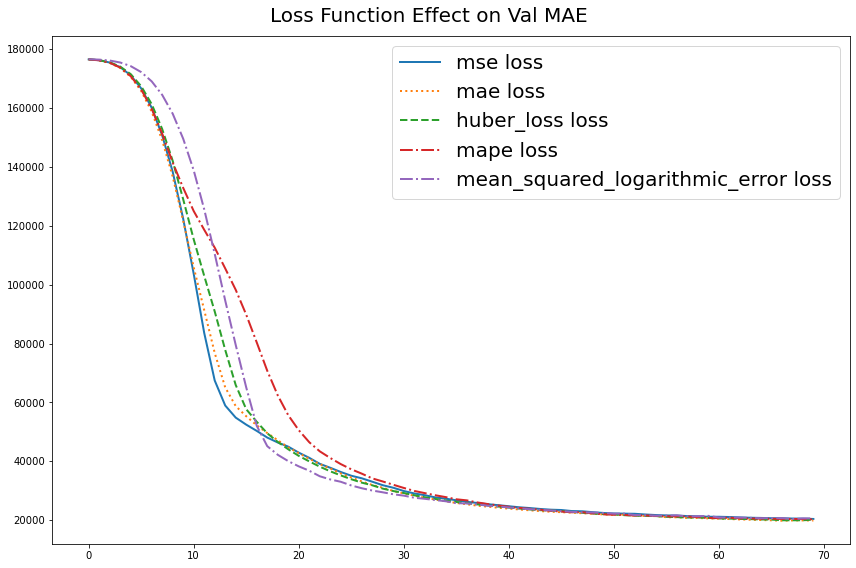

In [44]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle('Loss Function Effect on Val MAE', size=20)

linestyles = ['solid', 'dotted', 'dashed', 'dashdot', 'dashdot']
loss_functions = ['mse', 'mae', 'huber_loss', 'mape', 'mean_squared_logarithmic_error']

for index, history in enumerate(histories):
    history_df = pd.DataFrame(history.history)
    history_df['epoch'] = history.epoch
    num_epochs = history_df.shape[0]
    
    ax.plot(np.arange(0, num_epochs), 
            history_df["val_mae"], 
            label=f"{loss_functions[index]} loss",
            linestyle=linestyles[index], lw=2)
    

plt.legend(prop={'size': 20})
plt.tight_layout()
plt.show()

In [45]:
def define_model(optimizer):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
        layers.Dropout(0.3, seed=2),
        layers.Dense(64, activation='swish'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(loss='huber_loss',
                  optimizer=optimizer,
                  metrics=['mae', 'mse', 'mape'])
    
    return model

In [46]:
optimizers = ['rmsprop', 'adam', 'nadam']
histories = []

for index, optimizer in enumerate(optimizers, 1):
    model = define_model(optimizer)
    history = model.fit(
        X_train, y_train,
        epochs=70,
        validation_split=0.2,
        verbose=0)
    loss, mae, mse, mape = model.evaluate(X_test, y_test, verbose=0)
    print(f'Finished training model {index} with "{optimizer}" optimizer | MAE: {mae:.2f}, MSE: {mse:.2f}, MAPE: {mape:.2f}')
    histories.append(history)

Finished training model 1 with "rmsprop" optimizer | MAE: 19898.77, MSE: 1292153984.00, MAPE: 11.72
Finished training model 2 with "adam" optimizer | MAE: 19167.76, MSE: 1224723840.00, MAPE: 11.07
Finished training model 3 with "nadam" optimizer | MAE: 19388.99, MSE: 1270030720.00, MAPE: 11.29


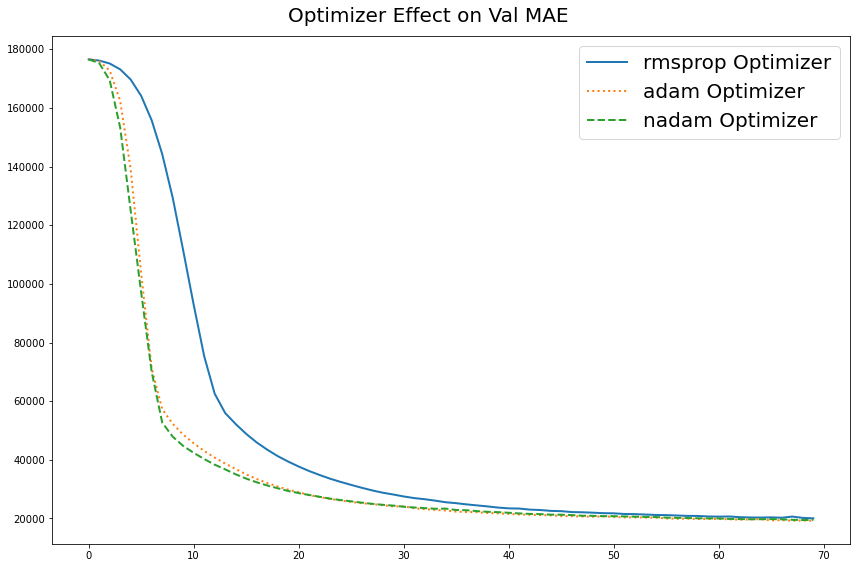

In [47]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle('Optimizer Effect on Val MAE', size=20)

linestyles = ['solid', 'dotted', 'dashed']
optimizers = ['rmsprop', 'adam', 'nadam']

for index, history in enumerate(histories):
    history_df = pd.DataFrame(history.history)
    history_df['epoch'] = history.epoch
    num_epochs = history_df.shape[0]
    
    ax.plot(np.arange(0, num_epochs), 
            history_df["val_mae"], 
            label=f"{optimizers[index]} Optimizer", 
            linestyle=linestyles[index], lw=2)
    

plt.legend(prop={'size': 20})
plt.tight_layout()
plt.show()

In [48]:
def define_model(num_layers):
    model = keras.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]))
    model.add(layers.Dropout(0.3, seed=2))
    
    for i in range(num_layers):
        if i%2==0:
            model.add(layers.Dense(64, activation='relu'))
        else:
            model.add(layers.Dense(64, activation='swish'))
            
    model.add(layers.Dense(64, activation='swish'))
    model.add(layers.Dense(1))

    model.compile(loss="huber_loss",
                  optimizer='adam',
                  metrics=['mae', 'mse', 'mape'])
    
    return model

In [49]:
sizes = [1, 2, 4, 8, 16]
histories = []

for index, size in enumerate(sizes, 1):
    model = define_model(size)
    history = model.fit(
        X_train, y_train,
        epochs=70,
        validation_split=0.2,
        verbose=0)
    loss, mae, mse, mape = model.evaluate(X_test, y_test, verbose=0)
    print(f'Finished training model {index} with size {size} | MAE: {mae:.2f}, MSE: {mse:.2f}, MAPE: {mape:.2f}')
    histories.append(history)

Finished training model 1 with size 1 | MAE: 19078.83, MSE: 1249403520.00, MAPE: 11.06
Finished training model 2 with size 2 | MAE: 18280.76, MSE: 1217572096.00, MAPE: 10.72
Finished training model 3 with size 4 | MAE: 17513.67, MSE: 1170516608.00, MAPE: 9.95
Finished training model 4 with size 8 | MAE: 18288.47, MSE: 1273814144.00, MAPE: 10.06
Finished training model 5 with size 16 | MAE: 18187.36, MSE: 1317853184.00, MAPE: 10.37


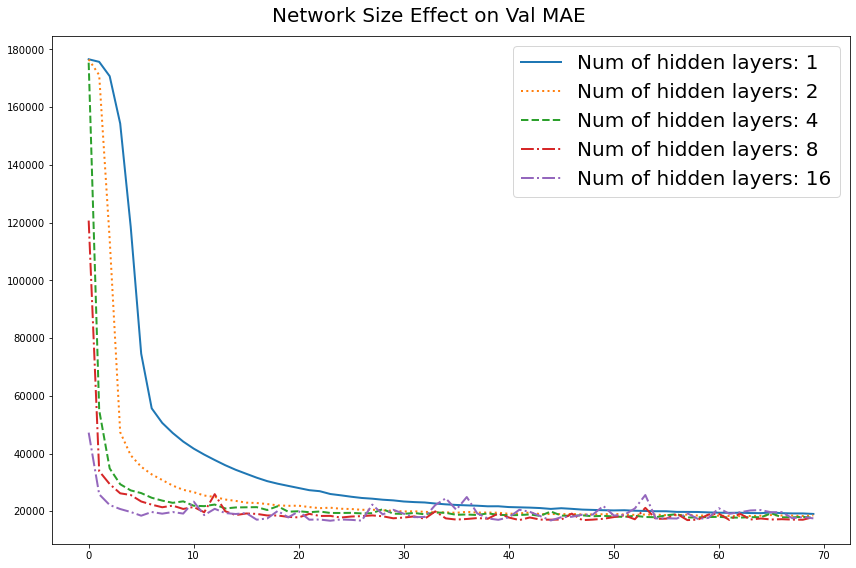

In [50]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle('Network Size Effect on Val MAE', size=20)

linestyles = ['solid', 'dotted', 'dashed', 'dashdot', 'dashdot']
sizes = [1, 2, 4, 8, 16]

for index, history in enumerate(histories):
    history_df = pd.DataFrame(history.history)
    history_df['epoch'] = history.epoch
    num_epochs = history_df.shape[0]
    
    ax.plot(np.arange(0, num_epochs), 
            history_df["val_mae"], 
            label=f"Num of hidden layers: {sizes[index]}", 
            linestyle=linestyles[index], lw=2)
    

plt.legend(prop={'size': 20})
plt.tight_layout()
plt.show()